## Importando bibliotecas

In [2]:
%matplotlib inline
%load_ext memory_profiler

import os
from os.path import join, getsize
import re
import urllib.request
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Preparando o dataset

In [4]:
urllib.request.urlretrieve('https://s3-sa-east-1.amazonaws.com/luizalabs-tech-challenges/movies.zip', 'movie.zip')

with open('movie.zip', 'rb') as f:
    z = zipfile.ZipFile(f)
    for name in z.namelist():
        try:
            z.extract(name, '.')
        except:
            pass

('movie.zip', <http.client.HTTPMessage at 0x5a955b0>)

## Problema

Esse problema pode ser dividido em quatro outros sub problemas, são eles:

    * listar arquivos de uma pasta
    * procurar uma substring em um texto
    * ler o conteudo de um arquivo
    * ordenar alfabeticamente

A baixo vou atacar cada problema separadamente com o objetivo de obter a maneira mais performática  de resolver cada um deles, tendo em mente que o objetivo é a menor velocidade de execução e o menor consumo de memória.

### Listar arquivos de uma pasta

In [53]:
#usando o walk
def get_files1(path):
    _, _, files = next(os.walk(path))
    return files
    
#usando o scandir
def get_files2(path):
    return os.scandir(path)
    
#usando o glob
def get_files3(path):
    return glob.glob(join(path, '*'))
    
#usando o listdir
def get_files4(path):
    return os.listdir(path)

#### Tempo de execução

In [54]:
a1 = %timeit -r 10 -o get_files1('data')
a2 = %timeit -r 10 -o get_files2('data')
a3 = %timeit -r 10 -o get_files3('data')
a4 = %timeit -r 10 -o get_files4('data')

28 ms ± 2.71 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
54.8 µs ± 2.43 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
83.9 ms ± 2.19 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
21 ms ± 712 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<Container object of 4 artists>

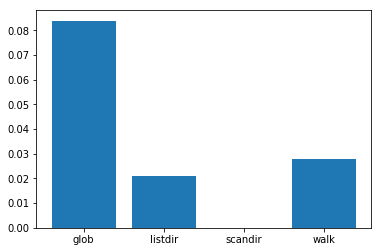

In [55]:
y = [a1.average, a2.average, a3.average, a4.average]
x = ['walk', 'scandir', 'glob', 'listdir']
plt.bar(x, y)

#### Consumo de mémoria

In [18]:
ma1 = %memit -r 10 -o get_files1('data')
ma2 = %memit -r 10 -o get_files2('data')
ma3 = %memit -r 10 -o get_files3('data')
ma4 = %memit -r 10 -o get_files4('data')

peak memory: 63.05 MiB, increment: 0.63 MiB
peak memory: 62.55 MiB, increment: 0.00 MiB
peak memory: 63.93 MiB, increment: 1.38 MiB
peak memory: 63.28 MiB, increment: 0.25 MiB


<Container object of 4 artists>

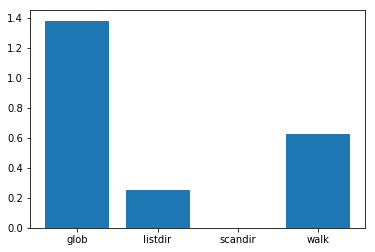

In [22]:
y = [
        max(ma1.mem_usage) - ma1.baseline, 
        max(ma2.mem_usage) - ma2.baseline, 
        max(ma3.mem_usage) - ma3.baseline, 
        max(ma4.mem_usage) - ma4.baseline, 
]

x = ['walk', 'scandir', 'glob', 'listdir']
plt.bar(x, y)

#### Conclusão

Para listar arquivos o `scandir` levou vantagem tanto no tempo de execução quanto no consumo de mémoria.

vencedor: `scandir` 

###  Procurar uma substring em um texto

In [36]:
def find_str1(content, q):
    return q in content

def find_str2(content, q):
    return content.find(q) > -1

def find_str3(content, q):
    return re.match(content, q)

#https://en.wikipedia.org/wiki/Rabin%E2%80%93Karp_algorithm
def find_str4(source, pattern):
    base = 26
    p_hash = 0
    s_hash = 0
    letter_position = lambda letter:  ord(letter) - ord('A')

    for letter in pattern:
        p_hash = p_hash * base + letter_position(letter)

    first_letter_base = base ** (len(pattern) - 1)
    for i, letter in enumerate(source):
        s_hash = s_hash * base + letter_position(letter)
        if i < len(pattern) - 1:
            continue

        match_start_index = i - len(pattern) + 1
        if s_hash == p_hash:
            return match_start_index

        s_hash = s_hash - letter_position(source[match_start_index]) *  first_letter_base
    return None


#https://en.wikipedia.org/wiki/Boyer%E2%80%93Moore_string_search_algorithm
def find_str5(text, pattern):
    m = len(pattern)
    n = len(text)
    if m > n: return -1
    skip = []
    for k in range(256): skip.append(m)
    for k in range(m - 1): skip[ord(pattern[k])] = m - k - 1
    skip = tuple(skip)
    k = m - 1
    while k < n:
        j = m - 1; i = k
        while j >= 0 and text[i] == pattern[j]:
            j -= 1; i -= 1
        if j == -1: return i + 1
        k += skip[ord(text[k])]
    return -1

In [54]:
#tamanho maximo do meu texto na minha base arquivos

sizeof_char = 1 # 1 byte
maxs = (biggest[1] / sizeof_char) + 1 # + /n

print("O maior texto da minha base de arquivos tem {} caracteres".format(maxs))

O maior texto da minha base de arquivos tem 171.0 caracteres


#### Tempo de execução

In [115]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'
q = 'obrigado'
s1 = %timeit -r 10 -o find_str1(content, q)
s2 = %timeit -r 10 -o find_str2(content, q)
s3 = %timeit -r 10 -o find_str3(content, q)
s4 = %timeit -r 10 -o find_str4(content, q)
s5 = %timeit -r 10 -o find_str5(content, q)

181 ns ± 2.81 ns per loop (mean ± std. dev. of 10 runs, 10000000 loops each)
349 ns ± 5.73 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
989 ns ± 6.7 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
61.5 µs ± 928 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
30.9 µs ± 474 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


<Container object of 5 artists>

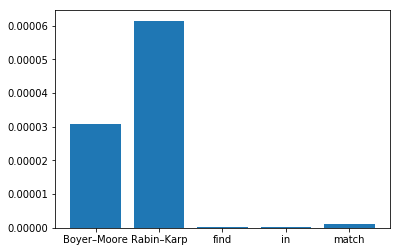

In [116]:
y = [s1.average, s2.average, s3.average, s4.average, s5.average]
x = ['in', 'find', 'match', 'Rabin–Karp', 'Boyer–Moore']
plt.bar(x, y)

#### Consumo de mémoria

In [43]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'
q = 'obrigado'
ms1 = %memit -r 10 -o find_str1(content, q)
ms2 = %memit -r 10 -o find_str2(content, q)
ms3 = %memit -r 10 -o find_str3(content, q)
ms4 = %memit -r 10 -o find_str4(content, q)
ms5 = %memit -r 10 -o find_str5(content, q)

peak memory: 55.75 MiB, increment: 0.03 MiB
peak memory: 55.75 MiB, increment: 0.00 MiB
peak memory: 55.75 MiB, increment: 0.00 MiB
peak memory: 55.75 MiB, increment: 0.00 MiB
peak memory: 55.73 MiB, increment: 0.00 MiB


<Container object of 5 artists>

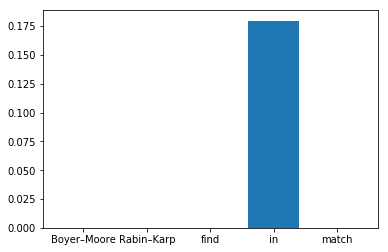

In [42]:
y = [
        max(ms1.mem_usage) - ms1.baseline, 
        max(ms2.mem_usage) - ms2.baseline, 
        max(ms3.mem_usage) - ms3.baseline, 
        max(ms4.mem_usage) - ms4.baseline, 
        max(ms5.mem_usage) - ms5.baseline, 
]

x = ['in', 'find', 'match', 'Rabin–Karp', 'Boyer–Moore']
plt.bar(x, y)

#### Conclusão

A performance desse problema esta relacionado oa tamanho do texto em que se realiza a busca. Para resolver usei os metodos nativos disponiveis no python3 (`in`, `find` e `match`), com a adição de mais dois algoritmos de busca em texto (`Rabin–Karp` e `Boyer–Moore`).

Em termos de tempo de execução os métodos nativos do python3, por serem implmentados em C, levaram vantagem mas
em relação ao consumo de mémoria as implementações adicionadas levaram a melhor.

vencendor: `in (nativo)`  

### Ler o conteudo de um arquivo 

In [37]:
#lendo o arquivo inteiro
def find1(path, q):
    with(open(path)) as f:
        content = f.read()
    return q in content


#lendo o arquivo em pedaços
def find2(path, q):
    with(open(path)) as f:
        length = len(q)
        part = f.read(length)
        
        while True:
            if part == q:
                return True

            char = f.read(1)
            
            if not char:
                return False

            part = part[1:] + char

            
#lendo o arquivo por linhas            
def find3(path, q):
     with(open(path)) as file:
        for line in file:
            if q in line:
                return True
        return False


In [35]:
#procurando o maior arquivo de nosso dataset

biggest = ('', -1)
path = 'data'

for item in os.listdir(path):
    item = join(path, item)
    itemsize = getsize(item)
    if itemsize > biggest[1]:
            biggest = (item, itemsize)

print('O maior arquivo é {} e tem {} bytes'.format(*biggest))

O maior arquivo é data\the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt e tem 170 bytes


#### Tempo de execução

In [40]:
hf1 = %timeit -r 10 -o find1('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    
hf2 = %timeit -r 10 -o find2('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    
hf3 = %timeit -r 10 -o find3('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    


120 µs ± 9.91 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
130 µs ± 3.57 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
109 µs ± 4.57 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


<Container object of 3 artists>

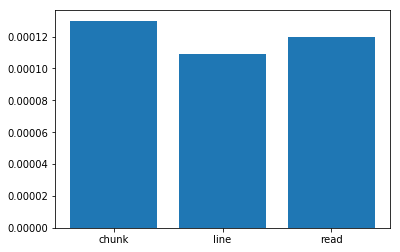

In [43]:
y = [hf1.average, hf2.average, hf3.average]
x = ['read', 'chunk', 'line']
plt.bar(x, y)

#### Consumo de mémoria

In [42]:
mhf1 = %memit -r 10 -o find1('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')  
mhf2 = %memit -r 10 -o find2('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')
mhf3 = %memit -r 10 -o find3('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    

peak memory: 50.68 MiB, increment: 0.00 MiB
peak memory: 50.68 MiB, increment: 0.00 MiB
peak memory: 50.68 MiB, increment: 0.00 MiB


<Container object of 3 artists>

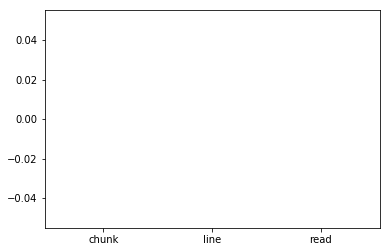

In [44]:
y = [
    max(mhf1.mem_usage) - mhf1.baseline, 
    max(mhf2.mem_usage) - mhf2.baseline, 
    max(mhf3.mem_usage) - mhf3.baseline,
]
x = ['read', 'chunk', 'line']
plt.bar(x, y)

#### Conclusão

Arquivos pequenos com pouco conteúdo podem ser carregados (`read`) de uma só vez para a mémoria. Já arquivos grandes precisam ser carregodos em pedaços (`chunks`) para que o consumo de mémoria se mantenha baixo, mas sendo penalizado com perda de velocidade. Ler o arquivos por linhas apresenta o melhor trade off, já que nossa base de arquivos é composta por arquivos de texto.

vencendor: `line in file`  

### Ordenar alfabeticamente

In [89]:
def sort1(results):
    return sorted(results)

def sort2(results):
    results.sort()
    return results

def quicksort(arr):
    if len(arr) < 2:
        return arr

    pivot = arr[0]
    lesser = quicksort([x for x in arr if x < pivot])
    greater = quicksort([x for x in arr if x > pivot])

    return lesser + [pivot] + greater

def merge(left, right):
    if not len(left) or not len(right):
        return left or right

    result = []
    i, j = 0, 0
    while (len(result) < len(left) + len(right)):
        if left[i] < right[j]:
            result.append(left[i])
            i+= 1
        else:
            result.append(right[j])
            j+= 1
        if i == len(left) or j == len(right):
            result.extend(left[i:] or right[j:])
            break 

    return result

def mergesort(list):
    if len(list) < 2:
        return list

    middle = int(len(list) / 2)
    left = mergesort(list[:middle])
    right = mergesort(list[middle:])

    return merge(left, right)

def ins_sort(k):
    for i in range(1,len(k)):
        j = i                    
        temp = k[j]              
        while j > 0 and temp < k[j-1]: 
            k[j] = k[j-1] 
            j=j-1 
        k[j] = temp
    return k

#### Tempo de execução

In [91]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'.split()
z1 = %timeit -r 10 -o sort1(content)
z2 = %timeit -r 10 -o sort2(content)
z3 = %timeit -r 10 -o quicksort(content)
z4 = %timeit -r 10 -o mergesort(content)
z5 = %timeit -r 10 -o ins_sort(content)

1.61 µs ± 24.6 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
580 ns ± 12.6 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
41.5 µs ± 467 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
52.7 µs ± 593 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
4.21 µs ± 12.3 ns per loop (mean ± std. dev. of 10 runs, 100000 loops each)


<Container object of 5 artists>

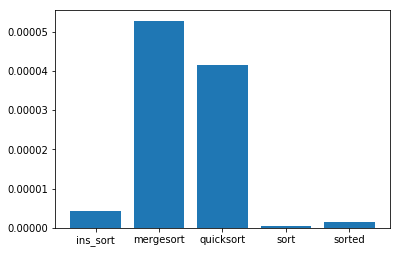

In [92]:
y = [z1.average, z2.average, z3.average, z4.average, z5.average]
x = ['sorted', 'sort', 'quicksort', 'mergesort', 'ins_sort']
plt.bar(x, y)

#### Consumo de mémoria

In [93]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'.split()
mz1 = %memit -r 10 -o sort1(content)
mz2 = %memit -r 10 -o sort2(content)
mz3 = %memit -r 10 -o quicksort(content)
mz4 = %memit -r 10 -o mergesort(content)
mz5 = %memit -r 10 -o ins_sort(content)

peak memory: 55.90 MiB, increment: 0.00 MiB
peak memory: 55.90 MiB, increment: 0.00 MiB
peak memory: 55.90 MiB, increment: 0.00 MiB
peak memory: 55.90 MiB, increment: 0.00 MiB
peak memory: 55.90 MiB, increment: 0.00 MiB


#### Conclusão

Foram testados os método de ordenação nativos do python3 (`sort`, `sorted`) ambos usam o `Timsort` que é o algoritmos de 
ordenação padrão do python, foram adicionados mais três algoritmos (`quicksort`, `mergesort`, `insertionsort`). 
As implementações nativas do python3 se mostraram superior, visto que são implementadas em C. Já entre o `sort` e o `sorted`, 
o primeiro levou vantagem por fazer a ordenação na própria instância da lista sem necessidade de criação de copias.

vencendor: `sort` 

## Soluções

Comparação entre diferentes propostas de solução

In [3]:
#solução simples

from search1 import search1
tsolucao1 = %timeit -r 10 -o search1('walt disney', 'data')
msolucao1 = %memit -r 10 -o search1('walt disney', 'data')

1.6 s ± 97.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 61.87 MiB, increment: 0.24 MiB


In [4]:
#solução com threads

from search2 import search2
tsolucao2 = %timeit -r 10 -o search2('walt disney', 'data')
msolucao2 = %memit -r 10 -o search2('walt disney', 'data')

1.22 s ± 52.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 65.68 MiB, increment: 1.21 MiB


In [5]:
#solução rodando em paralelo (com pool)

from search3 import search3
tsolucao3 = %timeit -r 10 -o search3('walt disney', 'data')
msolucao3 = %memit -r 10 -o search3('walt disney', 'data')

1.67 s ± 73.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.61 MiB, increment: 1.38 MiB


In [6]:
#solução rodando em paralelo (com fila)

from search4 import search4
tsolucao4 = %timeit -r 10 -o search4('walt disney', 'data')
msolucao4 = %memit -r 10 -o search4('walt disney', 'data')

2.25 s ± 63.8 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.77 MiB, increment: 0.20 MiB


In [7]:
#solução rodando em paralelo (com temp files)

from search5 import search5
tsolucao5 = %timeit -r 10 -o search5('walt disney', 'data')
msolucao5 = %memit -r 10 -o search5('walt disney', 'data')

1.08 s ± 93.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.82 MiB, increment: 0.15 MiB


In [8]:
#solução rodando em paralelo (com manager)

from search6 import search6
tsolucao6 = %timeit -r 10 -o search6('walt disney', 'data')
msolucao6 = %memit -r 10 -o search6('walt disney', 'data')

2.28 s ± 18 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.95 MiB, increment: 0.25 MiB


In [9]:
#solução rodando em paralelo (shared memory)

from search7 import search7
tsolucao7 = %timeit -r 10 -o search7('walt disney', 'data')
msolucao7 = %memit -r 10 -o search7('walt disney', 'data')

992 ms ± 50.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.77 MiB, increment: 0.00 MiB


In [10]:
#solução rodando em paralelo (consumer)

from search8 import search8
tsolucao8 = %timeit -r 10 -o search8('walt disney', 'data')
msolucao8 = %memit -r 10 -o search8('walt disney', 'data')

1.14 s ± 21.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.91 MiB, increment: 0.00 MiB


In [11]:
#solução rodando em paralelo (consumer/shared memory)

from search9 import search9
tsolucao9 = %timeit -r 10 -o search9('walt disney', 'data')
msolucao9 = %memit -r 10 -o search9('walt disney', 'data')

The slowest run took 12.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1.77 s ± 2.75 s per loop (mean ± std. dev. of 10 runs, 1 loop each)
peak memory: 70.91 MiB, increment: 0.04 MiB


#### Tempo de execução

<Container object of 7 artists>

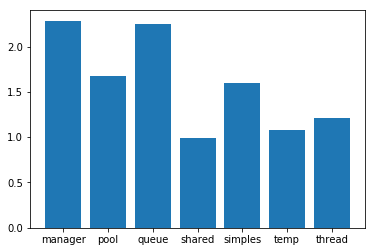

In [12]:
y = [
    tsolucao1.average,
    tsolucao2.average,
    tsolucao3.average,
    tsolucao4.average,
    tsolucao5.average,
    tsolucao6.average,    
    tsolucao7.average,
]
x = ['simples', 'thread', 'pool', 'queue', 'temp', 'manager', 'shared']
plt.bar(x, y)

#### Consumo de mémoria

<Container object of 9 artists>

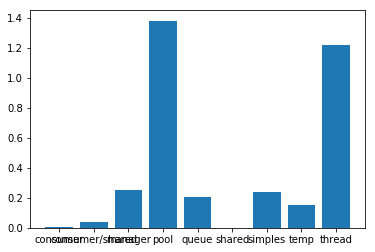

In [13]:
y = [
    max(msolucao1.mem_usage) - msolucao1.baseline,
    max(msolucao2.mem_usage) - msolucao2.baseline,
    max(msolucao3.mem_usage) - msolucao3.baseline,
    max(msolucao4.mem_usage) - msolucao4.baseline,
    max(msolucao5.mem_usage) - msolucao5.baseline,
    max(msolucao6.mem_usage) - msolucao6.baseline,    
    max(msolucao7.mem_usage) - msolucao7.baseline,
    max(msolucao8.mem_usage) - msolucao8.baseline,
    max(msolucao9.mem_usage) - msolucao9.baseline,
]
x = ['simples', 'thread', 'pool', 'queue', 'temp', 'manager', 'shared', 'consumer', 'consumer/shared']
plt.bar(x, y)

#### Conclusão